In [47]:
import numpy as np
import matplotlib.pyplot as plt

time: 714 µs (started: 2024-06-14 13:46:31 +00:00)


In [48]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16.5 s (started: 2024-06-14 13:46:32 +00:00)


In [49]:
np.set_printoptions(suppress = True, precision = 2)
rng = np.random.default_rng(seed = 1001)

time: 1.09 ms (started: 2024-06-14 13:46:48 +00:00)


In [50]:
def pca(X, k = 2):
    d, n = X.shape
    X -= X.mean(axis = 1).reshape(-1, 1)
    C = X @ X.T / n
    eigval, eigvec = np.linalg.eigh(C)
    W = eigvec[:, ::-1][:, :k]
    var = eigval[::-1][:k]
    return var, W

time: 17.2 ms (started: 2024-06-14 13:46:48 +00:00)


## Physics Example

In [51]:
# Direction vector
p = np.array([1., 2., 3.])
p /= np.linalg.norm(p)
# Speed
u = 2
# Time
T = 10
# Data
X = np.zeros((3, T))
for t in range(T):
    X[:, t] = u * t * p
d, n = X.shape
print(d, n)
print(X)

3 10
[[ 0.    0.53  1.07  1.6   2.14  2.67  3.21  3.74  4.28  4.81]
 [ 0.    1.07  2.14  3.21  4.28  5.35  6.41  7.48  8.55  9.62]
 [ 0.    1.6   3.21  4.81  6.41  8.02  9.62 11.22 12.83 14.43]]
time: 11.9 ms (started: 2024-06-14 13:46:48 +00:00)


In [52]:
var, W = pca(X)
assert np.allclose(W[:, 0], p)
print(var)

[33.  0.]
time: 8.85 ms (started: 2024-06-14 13:46:48 +00:00)


## Computational Cost

In [53]:
d, n = 1000, 100
X_1 = rng.uniform(size = (d, n))
d, n = 2000, 100
X_2 = rng.uniform(size = (d, n))

time: 16.8 ms (started: 2024-06-14 13:46:48 +00:00)


In [54]:
pca(X_1)

(array([1.41, 1.39]),
 array([[-0.01,  0.04],
        [ 0.01, -0.02],
        [ 0.02, -0.  ],
        ...,
        [ 0.03,  0.02],
        [-0.01, -0.08],
        [-0.  , -0.02]]))

time: 938 ms (started: 2024-06-14 13:46:48 +00:00)


In [55]:
pca(X_2)

(array([2.42, 2.37]),
 array([[ 0.01,  0.  ],
        [-0.02, -0.02],
        [-0.02,  0.  ],
        ...,
        [ 0.02, -0.01],
        [-0.02,  0.01],
        [-0.02,  0.02]]))

time: 8.07 s (started: 2024-06-14 13:46:49 +00:00)


In [56]:
def pca_mod(X, k = 2):
    d, n = X.shape
    K = X.T @ X
    eigval, eigvec = np.linalg.eigh(K)
    r = np.linalg.matrix_rank(K)
    var = eigval[::-1][:r]
    V = eigvec[:, ::-1][:, :r]
    W = np.zeros((d, r))
    for i in range(r):
        W[:, i] = X @ V[:, i] / np.sqrt(var[i])
    var /= n
    return var[:k], W[:, :k]

time: 4.29 ms (started: 2024-06-14 13:46:58 +00:00)


In [57]:
pca(X_1)

(array([1.41, 1.39]),
 array([[ 0.01, -0.04],
        [-0.01,  0.02],
        [-0.02,  0.  ],
        ...,
        [-0.03, -0.02],
        [ 0.01,  0.08],
        [ 0.  ,  0.02]]))

time: 1.05 s (started: 2024-06-14 13:46:58 +00:00)


In [58]:
pca_mod(X_1)

(array([1.41, 1.39]),
 array([[ 0.01,  0.04],
        [-0.01, -0.02],
        [-0.02, -0.  ],
        ...,
        [-0.03,  0.02],
        [ 0.01, -0.08],
        [ 0.  , -0.02]]))

time: 35.8 ms (started: 2024-06-14 13:46:59 +00:00)


In [59]:
pca_mod(X_2)

(array([2.42, 2.37]),
 array([[-0.01,  0.  ],
        [ 0.02, -0.02],
        [ 0.02,  0.  ],
        ...,
        [-0.02, -0.01],
        [ 0.02,  0.01],
        [ 0.02,  0.02]]))

time: 61.6 ms (started: 2024-06-14 13:46:59 +00:00)


## Kernel PCA

In [60]:
def kernel(x, y, p = 2, sigma = 1):
    if p == -1:
        return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))
    return (x @ y + 1) ** p

time: 6 ms (started: 2024-06-14 13:46:59 +00:00)


In [61]:
def kernel_PCA(X, k = 2, p = 2, center = False, sigma = 1):
    d, n = X.shape
    # Computing the kernel
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1):
            K[i][j] = kernel(X[:, i], X[:, j], p = p, sigma = sigma)
            K[j][i] = K[i][j]
    if center:
        # Centering the kernel
        ones = np.ones((n, n)) / n
        K_c = K - K @ ones - ones @ K + ones @ K @ ones
    else:
        K_c = K
    # Eigen-decomposition
    eigval, eigvec = np.linalg.eigh(K_c)
    r = np.linalg.matrix_rank(K_c)
    var = eigval[::-1][:r]
    V = eigvec[:, ::-1][:, :r]
    D = np.diag(1 / np.sqrt(var))
    # Extracting the representation
    X_prime = D @ V.T @ K_c
    var /= n
    return var, X_prime

time: 7.22 ms (started: 2024-06-14 13:46:59 +00:00)


### Example-0

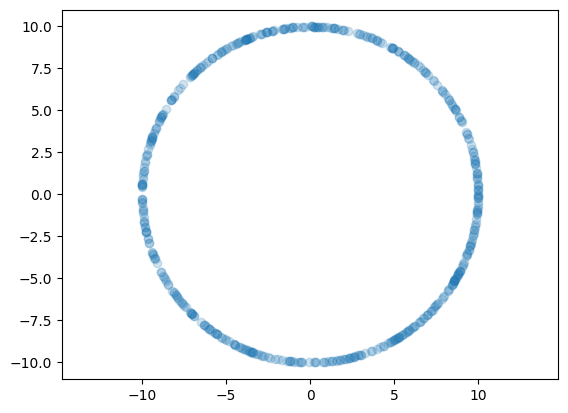

time: 569 ms (started: 2024-06-14 13:46:59 +00:00)


In [62]:
r = 10
n = 500
theta = rng.uniform(0, 2 * np.pi, size = n)
X = r * np.array([np.cos(theta), np.sin(theta)])
plt.axis('equal')
plt.scatter(X[0], X[1], alpha = 0.2)

In [63]:
var, X_prime = kernel_PCA(X, p = 2, center = True)
print(var)

[2541.81 2442.16  105.19   93.79]
time: 1.89 s (started: 2024-06-14 13:46:59 +00:00)


### Example-1

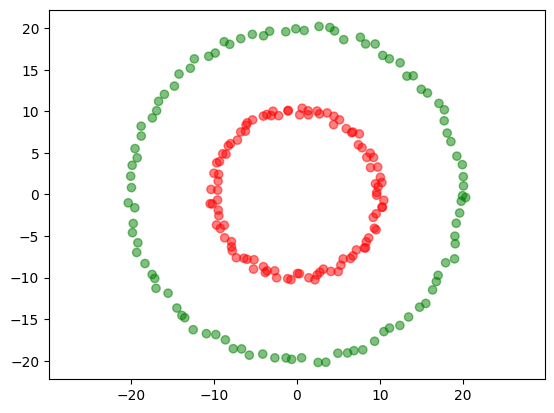

time: 525 ms (started: 2024-06-14 13:47:30 +00:00)


In [70]:
r = 10
n = 100
theta = np.linspace(0, 2 * np.pi, n)
X_1 = r * np.array([np.cos(theta), np.sin(theta)])
r = 20
X_2 = r * np.array([np.cos(theta), np.sin(theta)])
X = np.concatenate((X_1, X_2), axis = 1)
X += rng.uniform(-0.5, 0.5, (X.shape[0], X.shape[1]))
plt.axis('equal')
c = np.array(['red'] * n + ['green'] * n)
plt.scatter(X[0], X[1], c = c, alpha = 0.5)

45.4193866934076


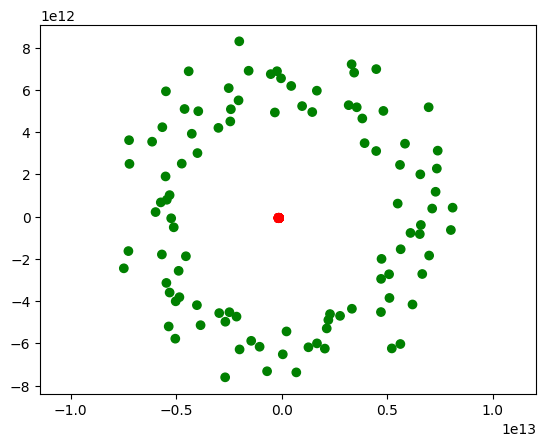

time: 917 ms (started: 2024-06-14 13:48:04 +00:00)


In [73]:
var, X_prime = kernel_PCA(X, p = 10, sigma = 1, center = True)
plt.axis('equal')
plt.scatter(X_prime[0], X_prime[1], c = c)
print(var[:2].sum() / var.sum() * 100)

### Example-2

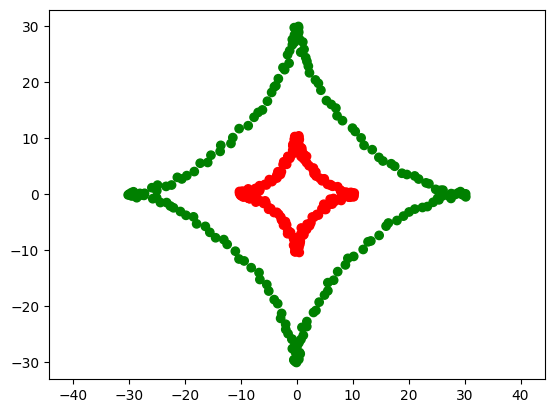

time: 601 ms (started: 2024-06-14 13:47:03 +00:00)


In [66]:
r = 10
n = 200
theta = np.linspace(0, 2 * np.pi, n)
X_1 = r * np.array([np.cos(theta) ** 3, np.sin(theta) ** 3])
r = 30
X_2 = r * np.array([np.cos(theta) ** 3, np.sin(theta) ** 3])
X = np.concatenate((X_1, X_2), axis = 1)
X += rng.uniform(-0.5, 0.5, (X.shape[0], X.shape[1]))
plt.axis('equal')
c = np.array(['red'] * n + ['green'] * n)
plt.scatter(X[0], X[1], c = c)

96.71045082550663


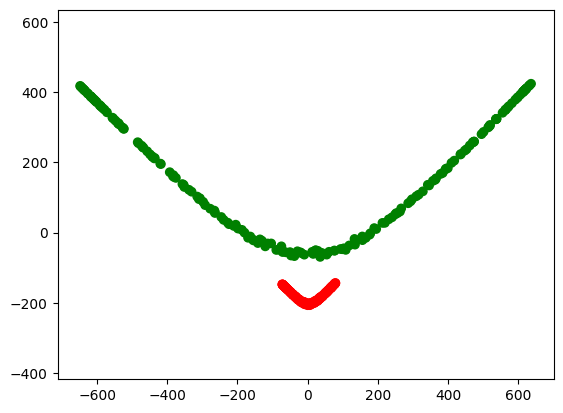

time: 2.6 s (started: 2024-06-14 13:47:03 +00:00)


In [67]:
var, X_prime = kernel_PCA(X, p = 2, center = True)
plt.axis('equal')
plt.scatter(X_prime[0], X_prime[1], c = c)
print(var[:2].sum() / var.sum() * 100)

### Example-3

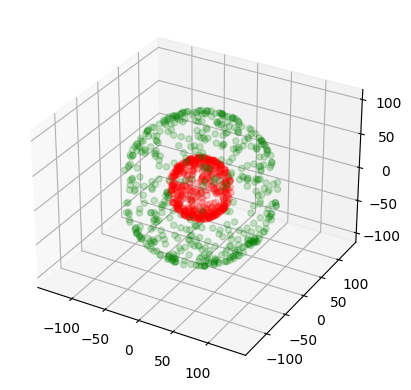

time: 1.16 s (started: 2024-06-14 13:47:06 +00:00)


In [68]:
def get_spherical_points(r, n):
    d = 3
    X = np.zeros((d, n))
    for i in range(n):
        x = rng.uniform(-r, r)
        y = rng.uniform(-np.sqrt(r ** 2 - x ** 2),
                    np.sqrt(r ** 2 - x ** 2))
        z = np.sqrt(r ** 2 - x ** 2 - y ** 2)
        if rng.uniform(0, 1) > 0.5:
            z *= -1
        X[:, i] = np.array([x, y, z])
    return X

n = 1000
X_1 = get_spherical_points(40, n // 2)
X_2 = get_spherical_points(100, n // 2)
X = np.concatenate((X_1, X_2), axis = 1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
c = ['red'] * (n // 2) + ['green'] * (n // 2)
ax.scatter(X[0], X[1], X[2], alpha = 0.2, c = c)
ax.axis('equal');

24.303091036420454


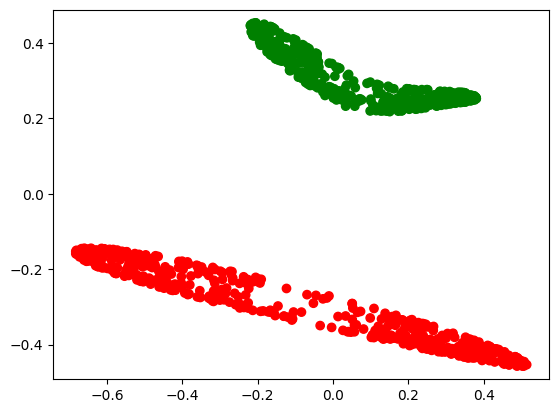

time: 21.8 s (started: 2024-06-14 13:47:07 +00:00)


In [69]:
var, X_prime = kernel_PCA(X, p = -1, sigma = 40, center = True)
plt.axis('equal')
plt.scatter(X_prime[0], X_prime[1], c = c)
print(var[:2].sum() / var.sum() * 100)